## Results notebook
---

Walking through the steps necessary to generate the results for the AKI Flagger paper. The main results are as follows: 

- the Venn (Euler) diagrams showing overlap between captured patient groups
- the number of patients in each group who go on to have worsening kidney function (proxied by progression in AKI stage), receive dialysis, or die. 
- 

In [1]:
!pip install akiFlagger
import akiFlagger
print(akiFlagger.__version__)


(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>DOSKEY ls=dir 

(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>cls
1.0.3


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.dates
import matplotlib.pyplot as plt

import os
import sys

import seaborn as sns
from akiFlagger import AKIFlagger
from matplotlib_venn import venn3

from sklearn.metrics import confusion_matrix, roc_auc_score

### User-defined functions

***
*plotAKIoverlap()* generates Euler plots (Venn diagrams) for the overlap between captured patient groups for each of the definitions

    Args:
        dataFRAME (pd.Dataframe) the dataframe with each of the AKI definitions
        stage (int) the stage of AKI to select by
        
*printDescriptiveStatistics()* prints the sensitivity, specificity, precision, F1 score, positive and negative predictive values (PPV/NPV) for a given (yTRUE, yPRED) pair combin

    Args: 
        dataFRAME (pd.Dataframe) the datamframe with each of the AKI definitions
        yTRUE (string) ground truth / outcome variable; expected to be a column in dataFRAME 
        yPRED (string) prediction / AKI definition; expected to be a column in the dataFRAME

In [3]:
def plotAKIoverlap(dataFRAME, stage = 1, returnCapturedPatients = False, plot = True):
    ''' Plotting function to illustrate the differences between which patient populations are captured by each definition
    '''
    captured_patients = dict()
    captured_patientsLIST = [set(dataFRAME[dataFRAME[col] > stage - 1].index.get_level_values(level='patient_id').unique()) for col in dataFRAME]
    captured_patients[flaggerDefinitions[0]], captured_patients[flaggerDefinitions[1]], captured_patients[flaggerDefinitions[2]] = captured_patientsLIST 

    if returnCapturedPatients & plot:
        return captured_patients, venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

    if returnCapturedPatients:
        return captured_patients
    
    if plot:
        return venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

def printDescriptiveStatistics(dataFRAME = None, level = "creatinine",
                               yTRUE = None, yPRED = None):
    ''' 
    For a given definition & percent increase, find the confusion matrix (& print corresponding descriptive statistics)
    Each of these. 
    '''

    #yTRUE = dataFRAME.outcome
    #yPRED = dataFRAME[AKIdefinitions[AKIdefinitions.index(definitionOfInterest)]]
    yTRUE = dataFRAME[yTRUE]
    yPRED = dataFRAME[yPRED]
    
    TN, FP, FN, TP = confusion_matrix(yTRUE, yPRED).ravel()
    AUC = roc_auc_score(yTRUE, yPRED)

    SENS = TP / (TP + FN)
    SPEC = TN / (TN + FP)
    PREC = TP / (TP + FP)
    F1Sc = 2*TP / (2*TP + (FP+FN))

    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)

    STATS = np.array([SENS, SPEC, PREC, F1Sc, PPV, NPV, AUC])

    print('''
    SENS: {}
    SPEC: {}
    PREC: {}
    F1 score: {}

    PPV: {}
    NPV: {}

    AUC: {}

    '''.format(*np.round(STATS, decimals = 3)))
    print("TN: {}, FP: {}. FN: {}, TP: {}".format(TN, FP, FN, TP), " <- CM raveled")

    return(confusion_matrix(yTRUE, yPRED))

def plotCreatinineTrajectory(MRN, rows = None, color = None):
    ''' Plot the creatinine trajectory (subslice) for the selected patient
    '''
    # Params
    draws = 10 # Number of draws
    lw_diff = 1.05 # Different line widths for each draw
    alpha = 0.03 # Alpha value for glow effect
    glow_size = 5 # glow linewidth
    if color is None:
        color = colors['jasmine']

    plotSubset = flaggerOutput.loc[flaggerOutput.index.get_level_values(level='patient_id') == MRN]
    plotSubset = plotSubset.merge(df.set_index(index).creatinine, on = index) # Add in the creatinine values from df
    if rows is not None:
        plotSubset = plotSubset[rows]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    for n in range(draws):
        ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color,
                linewidth = glow_size+(lw_diff*n), alpha=alpha)
        ax.tick_params(axis='x',which='both',bottom=False)
    ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color)
    ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(matplotlib.dates.MonthLocator(), defaultfmt='%m/%Y'))
    plt.xticks(rotation=30)
    #ax.set_xticklabels(plotSubset.index.get_level_values(level='time'), rotation=30)
    ax.set_xlabel('Time')
    ax.set_ylabel('Creatinine')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_facecolor(colors['lightgrey'])
    return ax

### Parameters
---

#### _General parameters_

*STAGE* is the staging of AKI; 1 2 or 3. 

*index* is a Python multi-index (id est hierarchical index) 

*flaggerDefinitions* 

#### _Flagger parameters_

The definitions are specified as boolean parameters within the internal function (the main `AKIFlagger` class and the `returnAKIpatients()` function). The dictionary is essentially a mapping between the flagger definitions are string inputs to the boolean inputs; a more human-readable input into a 3D bool vector. 

`padding` defaults to 4 hours; I am *explicitly* mentioning this here to make it clear (the first small divergence from the KDIGO definitions.

In [4]:
# Parameters
STAGE = 1 
index = ["patient_id", "time"]
flaggerDefinitions = ["RMW", "HBT", "BCI"]
dataFolder = r"H:\AKIFlagger\output"
dataPath = os.path.join(dataFolder, "flaggerInput.csv")
writeOutPath = os.path.join(dataFolder, "flaggerOutput.csv")
outcomesPath = os.path.join(dataFolder, "flaggerOutcomes.csv") #H:\AKIFlagger\output\flagger creatinine data 04-20-2022.csv
outcomeCols = ["death_time", "dialysis_time", "progression_time"]
selectCols = ["patient_id", "time", "inpatient", "creatinine", "age", "sex", "admission", # Flagger input columns
              "admit_creatinine"] + outcomeCols # Outcome columns
vennOutPath = "vennDiagrams" # Save directories
colors = {
    '###': 'green', # Replace ### with 
    '###': 'green', # 
    '###': 'red',   # (examplePatientsRMW)
    '###': 'green', # 
    '###': 'green',  # 5 mrns in total
    'mindaro': '#dbfe87', # Mindaro
    'jasmine': '#ffe381', # Jasmine
    'lightgrey': '#6f8695', # Light Slate Grey
    'boyblue': '#80A1D4', # Little Boy Blue
    'ivory': '#f6f7eb', # Ivory
    'cinnabar': '#e94f37', # Cinnabar
    'onyx': '#393e41', # Onyx
    'lavendar': '#eae8ff', # Lavendar
}

# Flagger-specific parameters
fParams = dict() # A mapping between definition strings and booleans
fParams[flaggerDefinitions[0]] = {"RM_window": True, "HB_trumping": False, "eGFR_impute": False}
fParams[flaggerDefinitions[1]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": False}
fParams[flaggerDefinitions[2]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": True}
padding = '4hours'

### Read in the data; take a peak at what the input looks like

In [5]:
# Read in data
pDF1 = pd.read_csv(dataPath)
pDF1['time'] = pd.to_datetime(pDF1.time)
pDF1 = pDF1.rename(columns= {"pat_mrn_id": "patient_id",
                             "hosp_admsn_time": "admission"})

pDF1 = pDF1.loc[:, selectCols]
flaggerInput = pDF1
outcomes = pDF1.loc[:, outcomeCols]
print(pDF1.shape)
#pDF1.head()

(499942, 11)


### Run the AKIFlagger 

In [6]:
# Run the flagger
_flaggerOutput = [AKIFlagger(**fParams[flaggerDefinitions[0]]).returnAKIpatients(flaggerInput).aki,
                    AKIFlagger(**fParams[flaggerDefinitions[1]]).returnAKIpatients(flaggerInput).aki,
                    AKIFlagger(**fParams[flaggerDefinitions[2]]).returnAKIpatients(flaggerInput).aki]
flaggerOutput = pd.concat([i for i in _flaggerOutput], axis = 1)
flaggerOutput.columns = ["RMW", "HBT", "BCI"]
print(flaggerOutput.shape)
print(flaggerInput.shape)
flaggerOutput.head()
# flaggerOutput.to_csv(writeOutPath, index=True)

**Runtime benchmarks**

`Size 1k    elapsed time: 10s 30s 40s`

`Size 5k    elapsed time: x`

`Size 50k   elapsed time:`

`Size 100k  elapsed time:`

`Size 200k  elapsed time:`

`Size 500k  elapsed time: 529s 531s 512s`

c:\Users\ishan\anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


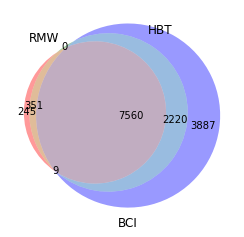

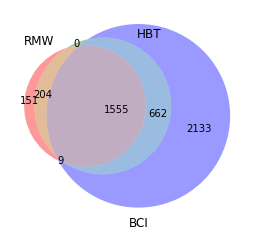

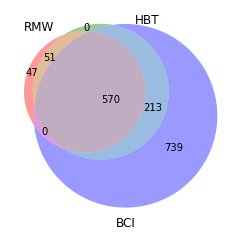

In [ ]:
STAGE = 1
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))

STAGE = 2
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))


STAGE = 3
plt.figure()
plotAKIoverlap(flaggerOutput, stage = STAGE)
#plt.savefig(os.path.join(dataFolder, vennOutPath, "01stage{}overlap.png".format(STAGE)))

In [ ]:
STAGE = 1
df = flaggerInput.merge(flaggerOutput > STAGE - 1, on = ["patient_id", "time"]) # Handles the boolean conversion
df['outcome'] = df['creatinine'] >= df['admit_creatinine']*2

# First, by creatinine
print("-------------------")
print("CONFUSION MATRICES: \n(creatinine-level)")
print("-------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'RMW')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'HBT')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'BCI')
print("----------------------------------------")

-------------------
CONFUSION MATRICES: 
(creatinine-level)
-------------------

    SENS: 0.713
    SPEC: 0.941
    PREC: 0.233
    F1 score: 0.351

    PPV: 0.233
    NPV: 0.992

    AUC: 0.827

    
TN: 458791, FP: 28874. FN: 3521, TP: 8756  <- CM raveled
----------------------------------------

    SENS: 0.74
    SPEC: 0.916
    PREC: 0.182
    F1 score: 0.293

    PPV: 0.182
    NPV: 0.993

    AUC: 0.828

    
TN: 446888, FP: 40777. FN: 3188, TP: 9089  <- CM raveled
----------------------------------------

    SENS: 0.781
    SPEC: 0.861
    PREC: 0.124
    F1 score: 0.214

    PPV: 0.124
    NPV: 0.994

    AUC: 0.821

    
TN: 419758, FP: 67907. FN: 2689, TP: 9588  <- CM raveled
----------------------------------------


In [ ]:
# Then, by patient

#combined_filterANY = flaggerOutput.groupby('patient_id').filter(lambda s: np.any(s))
# If extra time, see what combined_filterANY is returning
yPREDs = flaggerOutput.groupby('patient_id').any() # This is what I'm looking for : are there ANY 
df_ptlvl = yPREDs.merge(df.groupby('patient_id').outcome.any(), on = "patient_id")

# ez
print("-------------------")
print("CONFUSION MATRICES: \n(patient-level)")
print("-------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'RMW')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'HBT')
print("----------------------------------------")
printDescriptiveStatistics(dataFRAME = df_ptlvl, level = 'creatinine',
                           yTRUE = 'outcome', yPRED = 'BCI')
print("----------------------------------------")

-------------------
CONFUSION MATRICES: 
(patient-level)
-------------------

    SENS: 0.859
    SPEC: 0.824
    PREC: 0.17
    F1 score: 0.283

    PPV: 0.17
    NPV: 0.993

    AUC: 0.842

    
TN: 31714, FP: 6780. FN: 227, TP: 1385  <- CM raveled
----------------------------------------

    SENS: 0.883
    SPEC: 0.774
    PREC: 0.14
    F1 score: 0.242

    PPV: 0.14
    NPV: 0.994

    AUC: 0.828

    
TN: 29786, FP: 8708. FN: 189, TP: 1423  <- CM raveled
----------------------------------------

    SENS: 0.927
    SPEC: 0.684
    PREC: 0.109
    F1 score: 0.196

    PPV: 0.109
    NPV: 0.996

    AUC: 0.805

    
TN: 26313, FP: 12181. FN: 117, TP: 1495  <- CM raveled
----------------------------------------


<AxesSubplot:xlabel='time2aki', ylabel='Count'>

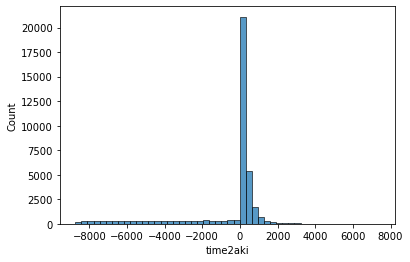

In [ ]:
# Define time to AKI event (from admission)

# df[~df['death_time'].isnull()]
df['aki.{}_time'.format(flaggerDefinitions[0])] = df[df.RMW > 0].time
df['time2aki'] = df['aki.RMW_time'] - pd.to_datetime(df.admission)
# plt.hist(df['time2aki'].astype('timedelta64[h]'))
# sns.distplot(df.time2aki.astype('timedelta64[h]'))
sns.histplot(df['time2aki'].astype('timedelta64[h]'), bins=50)

<AxesSubplot:xlabel='time2aki', ylabel='Count'>

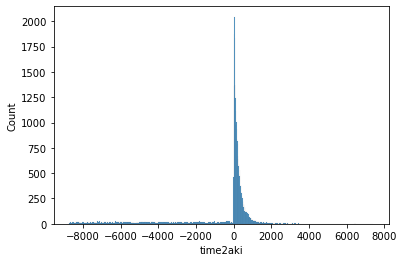

In [ ]:
#plt.hist(df['time2aki'].astype('timedelta64[h]'))
#sns.distplot(df.time2aki.astype('timedelta64[h]'))
sns.histplot(df['time2aki'].astype('timedelta64[h]'))

---

*changing up a bit here; work in progress...*

---


## Baseline creatinine function

Adding in the baseline creatinine and eGFR values for the patients

In [ ]:
#df = df.set_index(index)
baselineCreatDF = AKIFlagger(HB_trumping=True, add_baseline_creat = True).returnAKIpatients(flaggerOutput.merge(df.set_index(index).loc[:, ['creatinine', 'inpatient']], on=index))

In [ ]:
df

,patient_id,time,inpatient,creatinine,age,sex,admission,admit_creatinine,death_time,dialysis_time,progression_time,RMW,HBT,BCI,outcome,aki.RMW_time,time2aki
0,MR1000013,2020-09-23 23:08:00,True,0.92,27.169863,1,2020-12-14T02:14:00,0.75,NaN,NaN,NaN,False,False,False,False,NaT,NaT
1,MR1000013,2020-12-11 03:04:00,True,0.98,27.169863,1,2020-12-14T02:14:00,0.75,NaN,NaN,NaN,False,False,False,False,NaT,NaT
2,MR1000013,2020-12-12 10:40:00,True,0.91,27.169863,1,2020-12-14T02:14:00,0.75,NaN,NaN,NaN,False,False,False,False,NaT,NaT
3,MR1000013,2020-12-13 00:42:00,True,0.99,27.169863,1,2020-12-14T02:14:00,0.75,NaN,NaN,NaN,False,False,False,False,NaT,NaT
4,MR1000013,2020-12-14 03:35:00,True,0.75,27.169863,1,2020-12-14T02:14:00,0.75,NaN,NaN,NaN,False,False,False,False,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499937,MR999867,2020-06-10 08:41:00,True,0.40,82.345205,0,2020-06-03T06:45:00,0.80,NaN,NaN,NaN,False,False,False,False,NaT,NaT
499938,MR999867,2020-06-11 08:19:00,True,0.50,82.345205,0,2020-06-03T06:45:00,0.80,NaN,NaN,NaN,False,False,False,False,NaT,NaT
499939,MR999867,2020-06-12 08:31:00,True,0.60,82.345205,0,2020-06-03T06:45:00,0.80,NaN,NaN,NaN,True,True,True,False,2020-06-12 08:31:00,9 days 01:46:00
499940,MR999980,2020-05-31 20:49:00,True,0.80,21.986301,1,2020-05-31T18:47:00,0.80,NaN,NaN,NaN,False,False,False,False,NaT,NaT


In [ ]:
baselineCreatDF2 = AKIFlagger(HB_trumping=True, eGFR_impute=True, add_baseline_creat = True).returnAKIpatients(flaggerOutput.merge(df.set_index(index).loc[:, ['creatinine', 'inpatient', 'age', 'sex']], on=index))
baselineCreatDF2.head()

RMW  HBT  BCI  creatinine  inpatient  \
patient_id time                                                        
MR1000013  2020-09-23 23:08:00    0    0    0        0.92       True   
           2020-12-11 03:04:00    0    0    0        0.98       True   
           2020-12-12 10:40:00    0    0    0        0.91       True   
           2020-12-13 00:42:00    0    0    0        0.99       True   
           2020-12-14 03:35:00    0    0    0        0.75       True   

                                      age  sex  baseline_creat  aki  
patient_id time                                                      
MR1000013  2020-09-23 23:08:00  27.169863    1          1.0454    0  
           2020-12-11 03:04:00  27.169863    1          1.0454    0  
           2020-12-12 10:40:00  27.169863    1          1.0454    0  
           2020-12-13 00:42:00  27.169863    1          1.0454    0  
           2020-12-14 03:35:00  27.169863    1          1.0454    0

In [ ]:
baselineCreatDF3 = AKIFlagger(HB_trumping = True, add_baseline_creat=True).returnAKIpatients(flaggerOutput.merge(df.set_index(index).loc[:, ['creatinine', 'inpatient', 'age', 'sex']], on=index))
baselineCreatDF3.head()

creatinine  inpatient
patient_id time                                      
MR1000013  2020-09-23 23:08:00        0.92       True
           2020-12-11 03:04:00        0.98       True
           2020-12-12 10:40:00        0.91       True
           2020-12-13 00:42:00        0.99       True
           2020-12-14 03:35:00        0.75       True
...                                    ...        ...
MR999867   2020-06-10 08:41:00        0.40       True
           2020-06-11 08:19:00        0.50       True
           2020-06-12 08:31:00        0.60       True
MR999980   2020-05-31 20:49:00        0.80       True
           2020-06-02 06:33:00        0.63       True

[499942 rows x 2 columns]

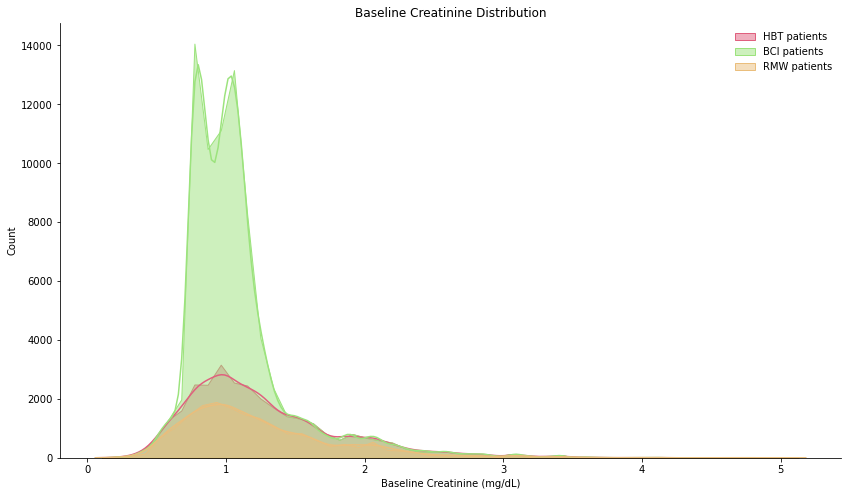

In [ ]:
# Parameters
BINS = 50
colors = {
    'purple': '#4B296B',
    'crimson': '#D7263D', 
    'nightblue': '#2E294E',
    'mint': '#B5FED9',
    'orange': '#E57A44',
    'forestgreen': '#423B0B',
    'meadowgreen': '#9CE37D',
    'apricot': '#F6C5AF',
    'blushpink': '#E0607E',
    'gold': '#EABE7C',
    'yellowgreen': '#D9DD92',
}

# Plotting
fig, ax = plt.subplots(nrows=1,ncols=1, frameon=False, figsize=(14,8))

sns.histplot(baselineCreatDF.loc[baselineCreatDF.HBT > 0].baseline_creat, label="HBT patients",
             bins=BINS, kde=True, color=colors['blushpink'], element="poly")
sns.histplot(baselineCreatDF2.loc[baselineCreatDF2.BCI > 0].baseline_creat, label="BCI patients",
             bins=BINS, kde=True, color=colors['meadowgreen'], element="poly")
sns.histplot(baselineCreatDF.loc[baselineCreatDF.RMW > 0].baseline_creat, label="RMW patients",
             bins=BINS, kde=True, color=colors['gold'], element="poly")



                  #kde_kws={"shade": True, "linewidth": 3}, rug_kws={"color": "black", "linewidth": 1})
#sns.distplot(baselineCreatDF.loc[baselineCreatDF.RMW > 0].baseline_creat, bins=20, kde=True, ax=ax)
ax.set_xlabel('Baseline Creatinine (mg/dL)')
ax.set_title('Baseline Creatinine Distribution')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("#fff")


In [ ]:
baselineCreatDF

RMW  HBT  BCI  creatinine  inpatient  \
patient_id time                                                        
MR1000013  2020-09-23 23:08:00    0    0    0        0.92       True   
           2020-12-11 03:04:00    0    0    0        0.98       True   
           2020-12-12 10:40:00    0    0    0        0.91       True   
           2020-12-13 00:42:00    0    0    0        0.99       True   
           2020-12-14 03:35:00    0    0    0        0.75       True   

                                baseline_creat  aki  
patient_id time                                      
MR1000013  2020-09-23 23:08:00             NaN    0  
           2020-12-11 03:04:00             NaN    0  
           2020-12-12 10:40:00             NaN    0  
           2020-12-13 00:42:00             NaN    0  
           2020-12-14 03:35:00             NaN    0

In [ ]:
quants = dict()
quants['RMW_baselinecreat'] = baselineCreatDF.loc[baselineCreatDF.RMW > 0].baseline_creat.quantile([0, 0.25, 0.5, 0.75, 1])
quants['HBT_baselinecreat'] = baselineCreatDF.loc[baselineCreatDF.HBT > 0].baseline_creat.quantile([0, 0.25, 0.5, 0.75, 1])
quants['BCI_baselinecreat'] = baselineCreatDF.loc[baselineCreatDF.BCI > 0].baseline_creat.quantile([0, 0.25, 0.5, 0.75, 1])
print(quants['RMW_baselinecreat'])
print('\n')
print(quants['HBT_baselinecreat'])
print('\n')
print(quants['BCI_baselinecreat'])

0.00    0.060
0.25    0.835
0.50    1.105
0.75    1.500
1.00    5.180
Name: baseline_creat, dtype: float64


0.00    0.060
0.25    0.870
0.50    1.135
0.75    1.530
1.00    4.810
Name: baseline_creat, dtype: float64


0.00    0.060
0.25    0.870
0.50    1.135
0.75    1.530
1.00    4.810
Name: baseline_creat, dtype: float64


<AxesSubplot:xlabel='creatinine', ylabel='Count'>

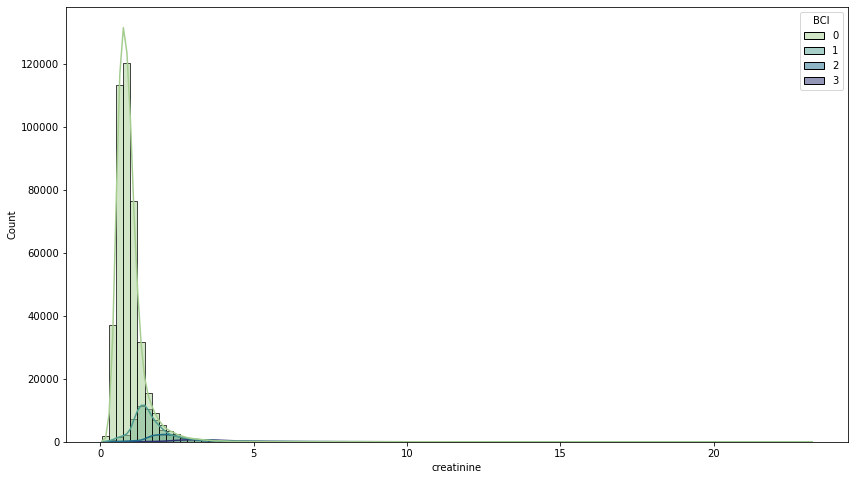

In [ ]:
plt.figure(figsize=(14,8))
sns.histplot(baselineCreatDF, x="creatinine", cbar=True, bins=100, kde=True, label='Creatinine Distribution',
             hue='BCI', palette="crest")

<AxesSubplot:xlabel='creatinine', ylabel='Count'>

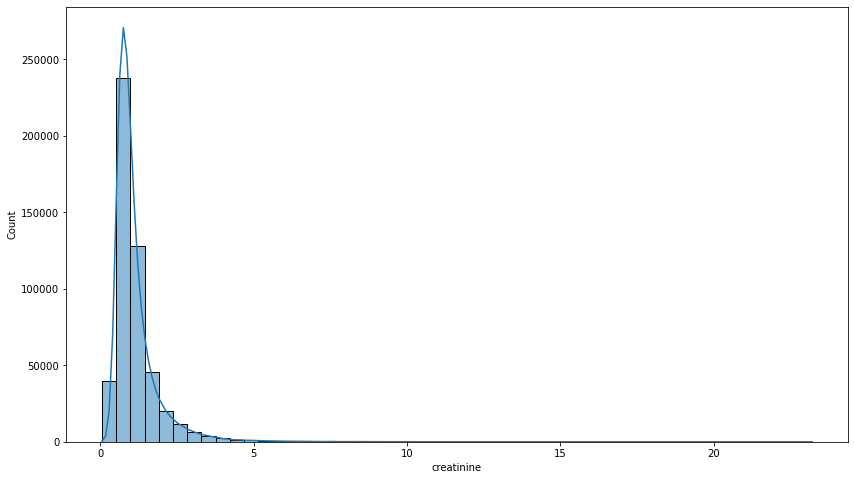

In [ ]:
plt.figure(figsize=(14,8))
sns.set_style()
sns.histplot(data=baselineCreatDF.creatinine, bins=50, kde=True)

In [ ]:
baselineCreatDF.creatinine.quantile(q=[0,0.25, 0.5,0.75, 0.95, 0.99])

0.00    0.06
0.25    0.70
0.50    0.91
0.75    1.28
0.95    2.50
0.99    4.17
Name: creatinine, dtype: float64

In [ ]:
baselineCreatDF

RMW  HBT  BCI  creatinine  inpatient  \
patient_id time                                                        
MR1000013  2020-09-23 23:08:00    0    0    0        0.92       True   
           2020-12-11 03:04:00    0    0    0        0.98       True   
           2020-12-12 10:40:00    0    0    0        0.91       True   
           2020-12-13 00:42:00    0    0    0        0.99       True   
           2020-12-14 03:35:00    0    0    0        0.75       True   
...                             ...  ...  ...         ...        ...   
MR999867   2020-06-10 08:41:00    0    0    0        0.40       True   
           2020-06-11 08:19:00    0    0    0        0.50       True   
           2020-06-12 08:31:00    1    1    1        0.60       True   
MR999980   2020-05-31 20:49:00    0    0    0        0.80       True   
           2020-06-02 06:33:00    0    0    0        0.63       True   

                                baseline_creat  aki  
patient_id time                                      
MR1000013  2020-09-23 23:08:00             NaN    0  
           2020-12-11 03:04:00             NaN    0  
           2020-12-12 10:40:00             NaN    0  
           2020-12-13 00:42:00             NaN    0  
           2020-12-14 03:35:00             NaN    0  
...                                        ...  ...  
MR999867   2020-06-10 08:41:00             NaN    0  
           2020-06-11 08:19:00             NaN    0  
           2020-06-12 08:31:00             NaN    1  
MR999980   2020-05-31 20:49:00             NaN    0  
           2020-06-02 06:33:00             NaN    0  

[499942 rows x 7 columns]